### Loading text file

In [1]:
file_path = 'the-verdict.txt'

with open(file_path, 'r', encoding='utf-8') as file:
    raw_text = file.read()

print('Total characters:', len(raw_text))

Total characters: 20479


### Splitting text into tokens

In [2]:
import re

preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text)
preprocessed = [item.strip() for item in preprocessed if item.strip()]
print(preprocessed[:30])

['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in']


### Converting tokens into token ids

In [3]:
all_words = sorted(set(preprocessed))
vocab_size = len(all_words)

print(vocab_size)

1130


In [4]:
vocab = {token:integer for integer,token in enumerate(all_words)}

# Print first 10 tokens and their corresponding IDs
print(list(vocab.items())[:10])

[('!', 0), ('"', 1), ("'", 2), ('(', 3), (')', 4), (',', 5), ('--', 6), ('.', 7), (':', 8), (';', 9)]


### Tokenizer class

In [5]:
class SimpletokenizerV1:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {i:s for s,i in vocab.items()}

    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        ids = [self.str_to_int[item] for item in preprocessed]
        return ids

    def decode(self, ids):
        text = ' '.join([self.int_to_str[item] for item in ids])
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text

tokenizer = SimpletokenizerV1(vocab)

In [6]:
text = """"It's the last he painted, you know," 
           Mrs. Gisburn said with pardonable pride."""
ids = tokenizer.encode(text)
print(ids)

[1, 56, 2, 850, 988, 602, 533, 746, 5, 1126, 596, 5, 1, 67, 7, 38, 851, 1108, 754, 793, 7]


In [7]:
tokenizer.decode(ids)

'" It\' s the last he painted, you know," Mrs. Gisburn said with pardonable pride.'

### Extending vocabulary
With special tokens, fx. unknown words and to seperate texts during training

In [8]:
all_tokens = sorted(list(set(preprocessed)))
all_tokens.extend(["<|endoftext|>", "<|unk|>"])

vocab = {token:integer for integer,token in enumerate(all_tokens)}

In [9]:
print(list(vocab.items())[-5:])

[('younger', 1127), ('your', 1128), ('yourself', 1129), ('<|endoftext|>', 1130), ('<|unk|>', 1131)]


In [10]:
class SimpleTokenizerV2:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = { i:s for s,i in vocab.items()}
    
    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        preprocessed = [
            item if item in self.str_to_int 
            else "<|unk|>" for item in preprocessed
        ]

        ids = [self.str_to_int[s] for s in preprocessed]
        return ids
        
    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        # Replace spaces before the specified punctuations
        text = re.sub(r'\s+([,.:;?!"()\'])', r'\1', text)
        return text

In [11]:
tokenizer = SimpleTokenizerV2(vocab)

text1 = "Hello, do you like tea?"
text2 = "In the sunlit terraces of the palace."

text = " <|endoftext|> ".join((text1, text2))

print(text)

Hello, do you like tea? <|endoftext|> In the sunlit terraces of the palace.


In [12]:
tokenizer.encode(text)

[1131, 5, 355, 1126, 628, 975, 10, 1130, 55, 988, 956, 984, 722, 988, 1131, 7]

In [13]:
tokenizer.decode(tokenizer.encode(text))

'<|unk|>, do you like tea? <|endoftext|> In the sunlit terraces of the <|unk|>.'

Some tokenizers use special tokens to help the LLM with additional context
    - Some of these special tokens are,
      - `[BOS]` (beginning of sequence) marks the beginning of text,
      - `[EOS]` (end of sequence) marks where the text ends (this is usually used to concatenate multiple unrelated texts, e.g., two different Wikipedia articles or two different books, and so on),
      - `[PAD]` (padding) if we train LLMs with a batch size greater than 1 (we may include multiple texts with different lengths; with the padding token we pad the shorter texts to the longest length so that all texts have an equal length),
    - `[UNK]` to represent words that are not included in the vocabulary


    - Note that GPT-2 does not need any of these tokens mentioned above but only uses an `<|endoftext|>` token to reduce complexity,
    - The `<|endoftext|>` is analogous to the `[EOS]` token mentioned above,
    - GPT also uses the `<|endoftext|>` for padding (since we typically use a mask when training on batched inputs, we would not attend padded tokens anyways, so it does not matter what these tokens are),
    - GPT-2 does not use an `<UNK>` token for out-of-vocabulary words; instead, GPT-2 uses a byte-pair encoding (BPE) tokenizer, which breaks down words into subword units which we will discuss in a later section\,

**Common special tokens**

- `[BOS]` (beginning of sequence) marks the beginning of text
- `[EOS]` (end of sequence) marks where the text ends (this is usually used to concatenate multiple unrelated texts, e.g., two different Wikipedia articles or two different books, and so on)
- `[PAD]` (padding) if we train LLMs with a batch size greater than 1 (we may include multiple texts with different lengths; with the padding token we pad the shorter texts to the longest length so that all texts have an equal length)
- `[UNK]` to represent words that are not included in the vocabulary

Note that GPT-2 does not need any of these tokens mentioned above but only uses an `<|endoftext|>` token to reduce complexity

- The `<|endoftext|>` is analogous to the `[EOS]` token mentioned above

GPT also uses the `<|endoftext|>` padding (since we typically use a mask when training on batched inputs, we would not attend padded tokens anyways, so it does not matter what these tokens are)

GPT-2 does not use an `<UNK>` token for out-of-vocabulary words; instead, GPT-2 uses a byte-pair encoding (BPE) tokenizer, which breaks down words into subword units which we will discuss in a later section

### BPE Tokenizer
- GPT-2 used BytePair encoding (BPE) as its tokenizer
- it allows the model to break down words that aren't in its predefined vocabulary into smaller subword units or even individual characters, enabling it to handle out-of-vocabulary words
- For instance, if GPT-2's vocabulary doesn't have the word "unfamiliarword," it might tokenize it as ["unfam", "iliar", "word"] or some other subword breakdown, depending on its trained BPE merges
- The original BPE tokenizer can be found here: https://github.com/openai/gpt-2/blob/master/src/encoder.py

In [14]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

In [15]:
text = (
    "Hello, do you like tea? <|endoftext|> In the sunlit terraces"
     "of someunknownPlace."
)

integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"}
                            )

print(integers)

[15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 1659, 617, 34680, 27271, 13]


In [16]:
strings = tokenizer.decode(integers).strip()
print(strings)


Hello, do you like tea? <|endoftext|> In the sunlit terracesof someunknownPlace.


## Data sampling
With a sliding window

![alt text](image.png)

In [17]:
enc_text = tokenizer.encode(raw_text)
enc_sample = enc_text[50:]

In [18]:
context_size = 4 
x = enc_sample[:context_size]
y = enc_sample[1:context_size+1]
print(f'x: {x}')
print(f'y"      {y}')

x: [290, 4920, 2241, 287]
y"      [4920, 2241, 287, 257]


In [19]:
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]

    print(context, "---->", desired)

[290] ----> 4920
[290, 4920] ----> 2241
[290, 4920, 2241] ----> 287
[290, 4920, 2241, 287] ----> 257


# Converting input and target to tensors
For illustrative purposes the tensors are filled with strings, whereas in practice these will be the token IDs

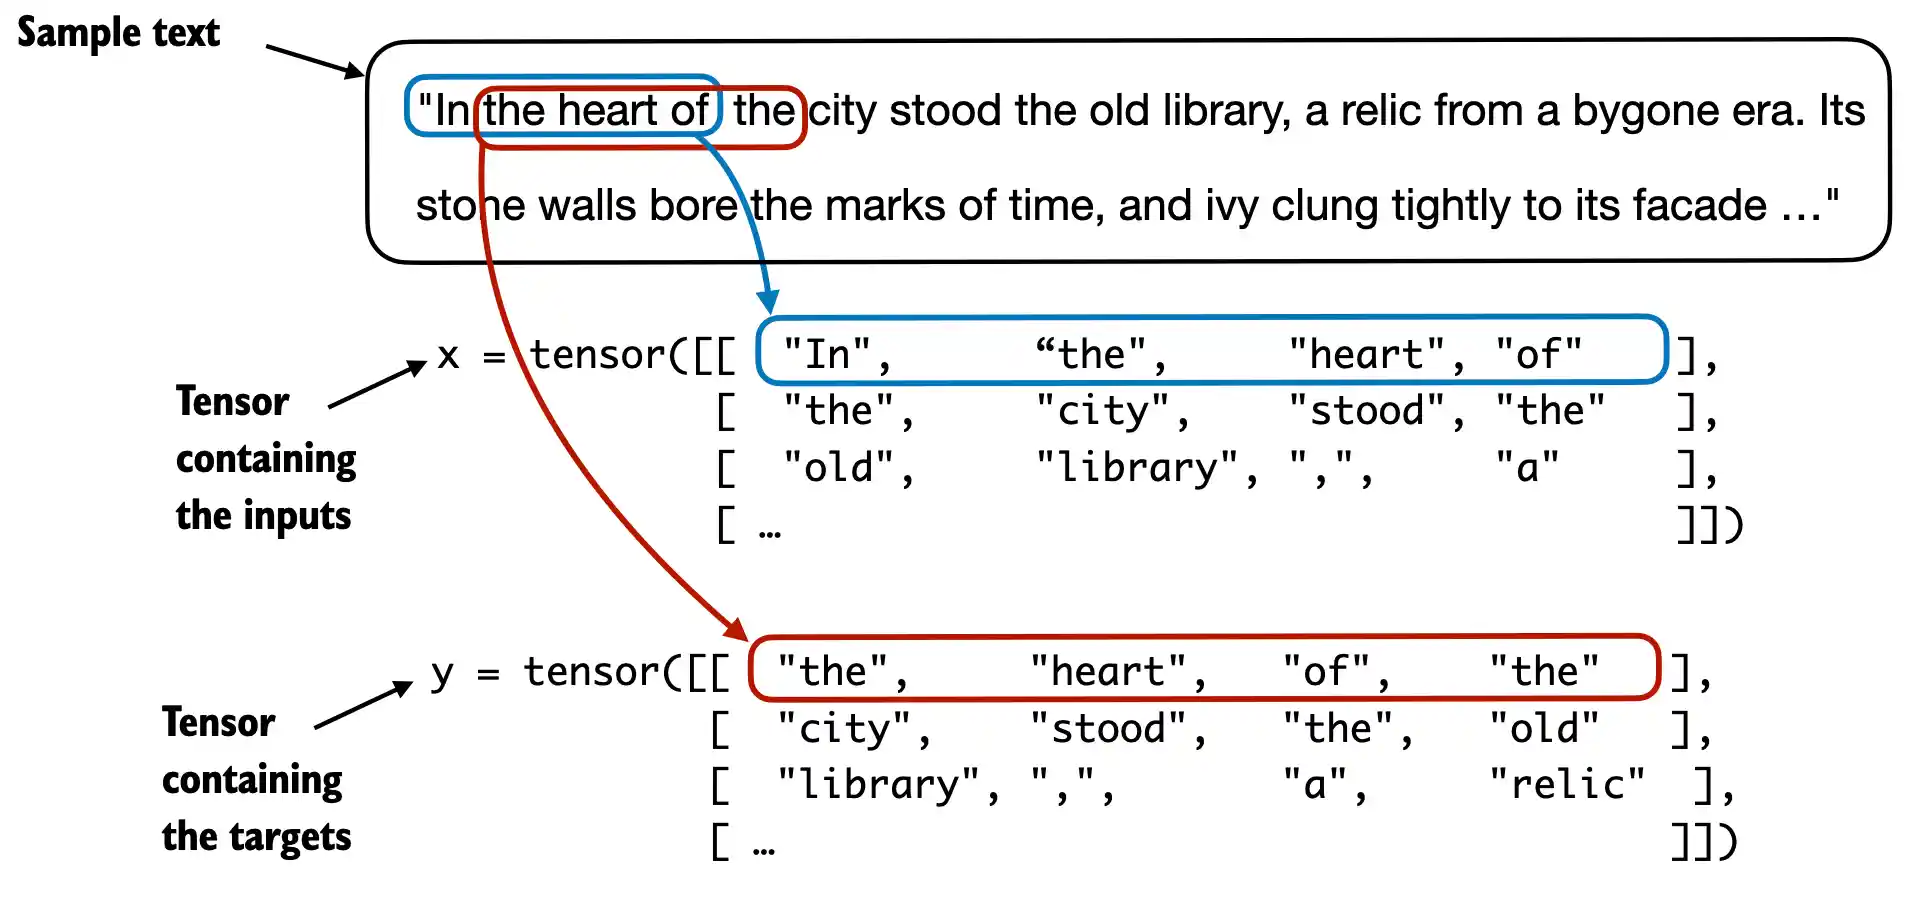

In [21]:
import torch
print("PyTorch version:", torch.__version__)

PyTorch version: 2.6.0.dev20241112


In [23]:
import torch
from torch.utils.data import Dataset, DataLoader

class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(text)

        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1:i + 1 + max_length]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):    
        return self.input_ids[idx], self.target_ids[idx]